In [129]:
# depth_mapping.ipynb

# Python notebook for prototyping implementation for 3D depth mapping algorithm from the following paper:
# J. Wlodek, K. J. Gofron, Y. Q. Cai; Achieving 3D imaging through focus stacking.
# AIP Conf. Proc. 15 January 2019; 2054 (1): 050001. https://doi.org/10.1063/1.5084619

# Bennett Wu - 11/17/2023

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cv2

In [130]:
def load_image(path: os.PathLike) -> np.array:
    try:
        bgr_img = cv2.imread(path)
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        return rgb_img.astype('float32') / np.max(rgb_img)
    except:
        raise Exception(f'Failed to load image: {path}')


def rgb_to_gray(im: np.array) -> np.array:
    return cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)


def plt_img(ax: plt.axis, img: np.array, title='') -> None:
    cmap = 'gray'
    if (len(img.shape) == 3 and img.shape[2] == 3):
        cmap = None
    ax.imshow(img, cmap=cmap)
    ax.axis('off')
    if title:
        ax.set_title(title)

In [131]:
def gaussian_kernel(sigma: float, kernel_half_size: int) -> np.array:
    window_size = kernel_half_size*2+1
    gaussian_kernel_1d = sp.signal.windows.gaussian(
        window_size, std=sigma).reshape(window_size, 1)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
    gaussian_kernel_2d /= np.sum(gaussian_kernel_2d)

    return gaussian_kernel_2d


def gauss_convolve(im: np.array, ksize: int) -> np.array:
    assert ksize % 2 == 1  # ksize must be odd
    return cv2.GaussianBlur(im, (ksize, ksize), 0)


def laplacian_convolve(im: np.array, ksize: int) -> np.array:
    assert ksize % 2 == 1  # ksize must be odd
    return cv2.Laplacian(im, ddepth=cv2.CV_32F, ksize=ksize)

In [132]:
img_dir = './test_images/'
img_names = [
    '1.jpg', '2.jpg'
]

focal_depths = [
    1, 100
]

focal_depths = np.array(focal_depths)
images = np.array([load_image(os.path.join(img_dir, name)) for name in img_names])

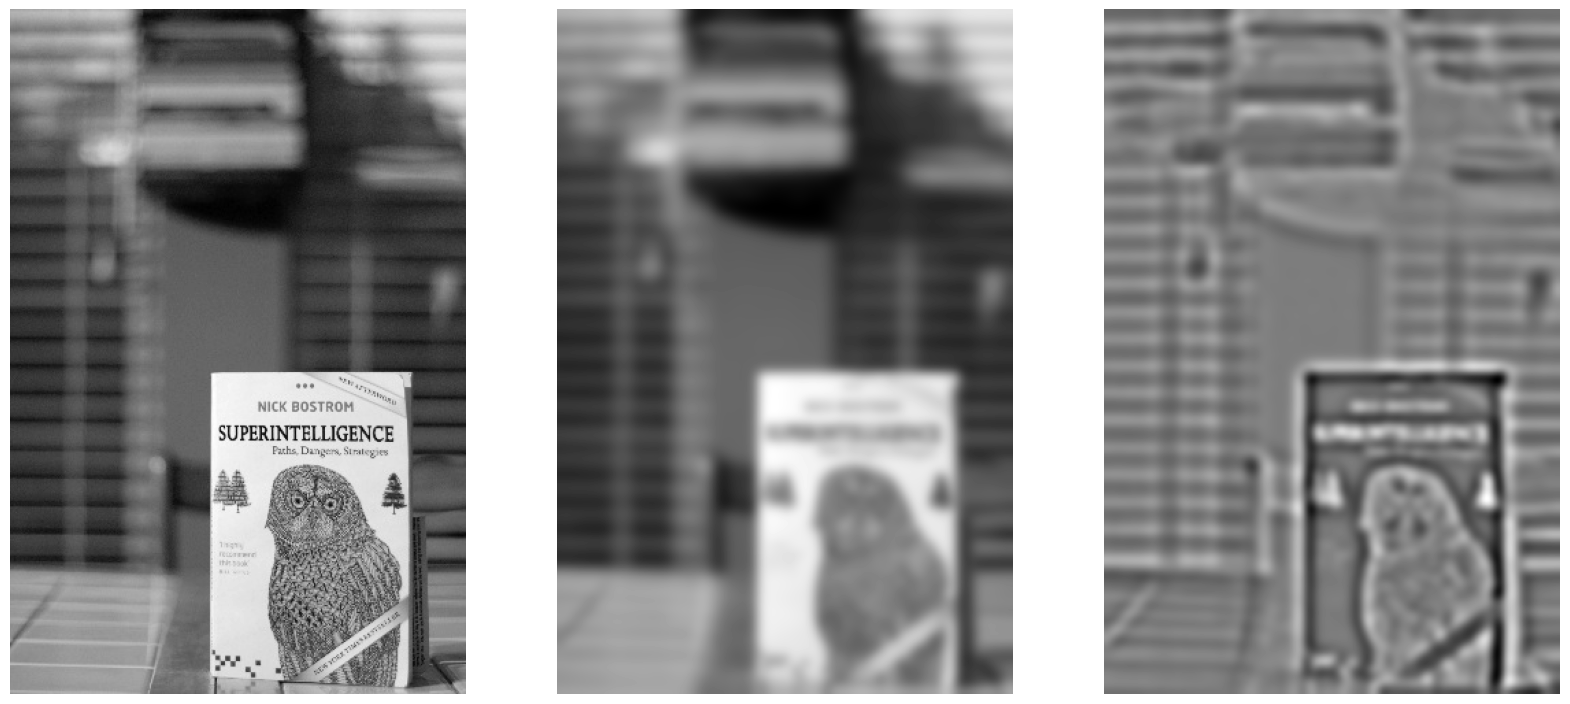

In [133]:
img = rgb_to_gray(images[0])
blur = gauss_convolve(img, 25)
sharp = laplacian_convolve(blur, 25)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
plt_img(ax[0], img)
plt_img(ax[1], blur)
plt_img(ax[2], sharp)


In [134]:
def sharpness_vals(images: np.array, gauss_ksize: int, lap_ksize: int) -> np.array:
    assert gauss_ksize % 2 == 1  # ksize must be odd
    assert lap_ksize % 2 == 1  # ksize must be odd

    sharp_values = []
    for image in images:
        img = rgb_to_gray(image)
        blur = gauss_convolve(img, gauss_ksize)
        sharp = laplacian_convolve(blur, lap_ksize)
        sharp_values.append(sharp)

    return np.array(sharp_values)


def depth_mapping(images: np.array, focal_depths: np.array, gauss_ksize: int, lap_ksize: int):
    sharp_values = sharpness_vals(images, gauss_ksize, lap_ksize)
    max_sharp = np.argmax(sharp_values, axis=0)

    stacked = np.zeros((max_sharp.shape[0], max_sharp.shape[1], 3))
    for r in range(max_sharp.shape[0]):
        for c in range(max_sharp.shape[1]):
            stacked[r, c] = images[max_sharp[r, c], r, c, :]

    depth_map = focal_depths[max_sharp]
    return depth_map, stacked

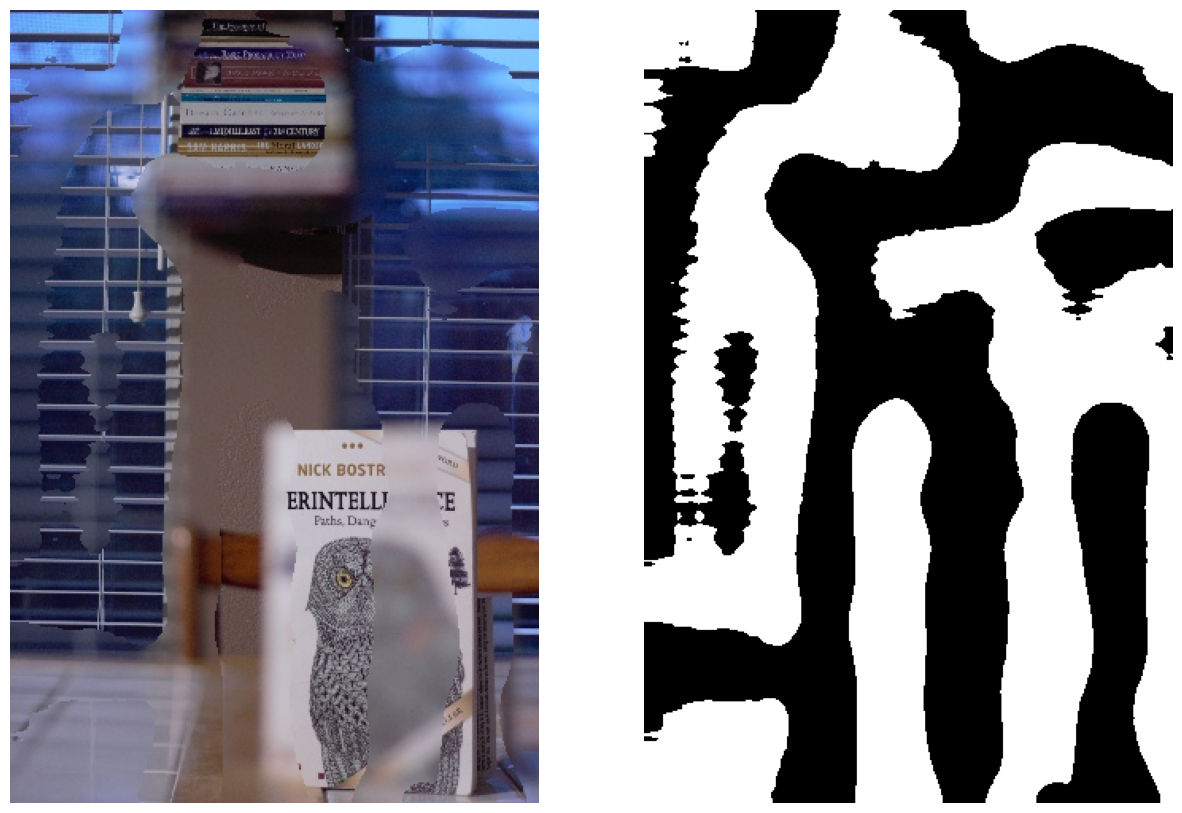

In [135]:
depth, stack = depth_mapping(images, focal_depths, 151, 15)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt_img(ax[0], stack)
plt_img(ax[1], depth)